In [1]:
%matplotlib inline

import numpy as np
import scipy.stats as stats
import scipy.special as special
import matplotlib.pyplot as plt
import matplotlib
import astropy.io.fits as fits

matplotlib.rc('xtick',labelsize=12)
matplotlib.rc('ytick',labelsize=12)


# read a sample velocity data
y = np.loadtxt('Vlos.dat')
print type(y)

<type 'numpy.ndarray'>


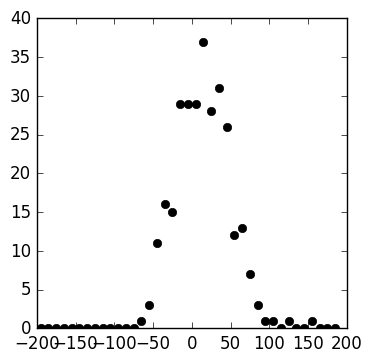

In [3]:
# draw histogram
vgrid = np.arange(-200,200,10)
vcenter = (vgrid[1:]+vgrid[:-1])/2.

hv,xedge = np.histogram(y,vgrid)

fig = plt.figure(figsize=[4,4])
ax = fig.add_subplot(111)
ax.plot(vcenter, hv, 'ko')
ax.set_label('V')

fig.show()

y_bar = 14.260 km/s,  s2 = 1162.481 km^2/s^2


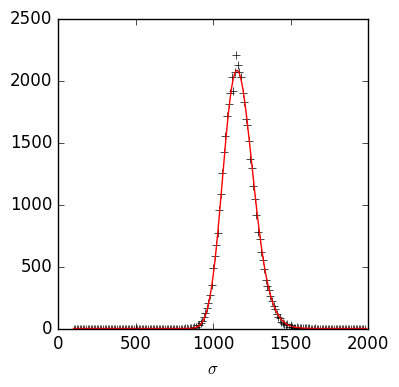

In [4]:
#ask for the mean velocity and the velocity dispersion, 
#providing that the velocity distributionis Gaussian
#known mean redshift ask dispersion, as homework
def logit(x):
    return np.log10(x/(1.-x))

def InvGammaln(x,alpha,beta):
    return np.log(beta)*alpha-(special.gammaln(alpha))+\
           np.log(x)*(-alpha-1)-beta/x

def Scl_InvChi2ln(x, nu, s2):
    return InvGammaln(x, nu/2.,nu/2.*s2)

def randDraw_SInvChi2(nu,s2, N):
    x = []
    k = 0
    m = 0
    while k<N and m <= 3:
        x0 = np.random.uniform(low=0,high=2000,size=N*20)
        y0 = np.log(np.random.uniform(low=0,high=0.006,size=N*20))
        #x0 = logit(x0)
        y1 = Scl_InvChi2ln(x0, nu, s2)
        
        ind = (y0<y1)
        x.append(x0[ind])
        k = k + np.sum(ind)
        m += 1
        #print k,m
    xx = np.array(x).reshape((k,1))
    
    return (xx[0:N])

# sampling
n = len(y)
y_bar = np.sum(y)/n #np.mean(y)
s2 = np.sum((y-y_bar)**2)/(n-1.) #np.var(y)
print r'y_bar = %(y).3f km/s,  s2 = %(s).3f km^2/s^2' %\
     {'y':y_bar, 's':s2}
#step 1: draw sigma2 from posterior density of 
#        sigma2 given v, p(sigma2|y)
N = 50000
sigma2 = randDraw_SInvChi2(n-1,s2, N)

#draw the random draw of sigma
x = np.arange(100,2000,10)
y1 = np.exp(Scl_InvChi2ln(x, n-1, s2))
hy,xedge = np.histogram(sigma2,x)

fig = plt.figure(figsize=[4,4])
ax = fig.add_subplot(111)
ax.plot(x[0:-1],hy,'k+')
ax.plot(x,y1/sum(y1)*sum(hy),'r')
ax.set_xlabel(r'$\sigma$',fontsize=12)
fig.show()

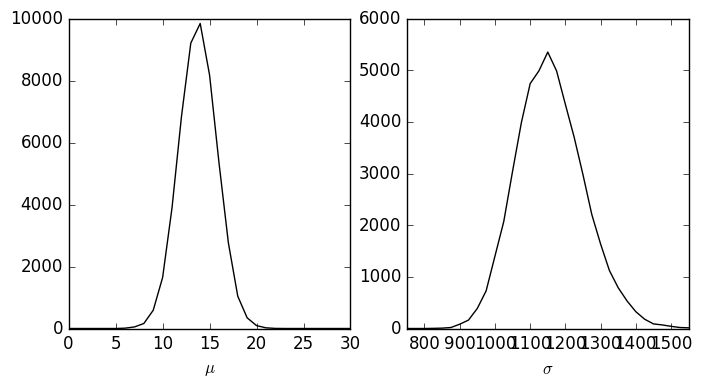

In [5]:
#step 2 : draw mu from p(mu|sigma2,y)
mu = np.random.normal(loc=y_bar, scale=np.sqrt(sigma2/n))
#step 3: marginalize over sigma2
#draw the random draw of sigma
x = np.arange(-30,50,1)
hy,xedge = np.histogram(mu,x)
s = np.arange(500,2500,25)
hs,xedge = np.histogram(sigma2,s)

#draw the marginal density for mu
fig = plt.figure(figsize=[8,4])
ax = fig.add_subplot(121)
ax.plot(x[0:-1],hy,'k')
ax.set_xlabel(r'$\mu$',fontsize=12)
ax.set_xlim([0,30])

#draw the marginal density for sigma
ax = fig.add_subplot(122)
ax.plot(s[0:-1],hs,'k')
ax.set_xlabel(r'$\sigma$',fontsize=12)
ax.set_xlim([750,1550])
fig.show()


In [6]:
#obtain the statistics from the sampling
print 'mu = %(m).3f+/-%(s).3f' % {'m': np.mean(mu), 's': np.std(mu)}
print 'sigma = %(m).3f+/-%(s).3f' % {'m': np.mean(np.sqrt(sigma2)), 's': np.std(np.sqrt(sigma2))}

mu = 14.267+/-1.995
sigma = 34.190+/-1.412


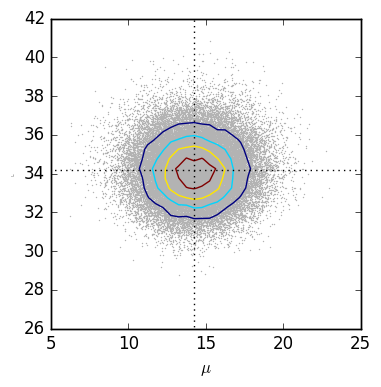

In [10]:
#draw joint posterior distribution for (mu, sigma)
xgrid = np.arange(-10,40,0.5)
ygrid = np.arange(25,45,0.5)
xcenter = (xgrid[:-1]+xgrid[1:])/2,
ycenter = (ygrid[:-1]+ygrid[1:])/2,
xmesh, ymesh = np.meshgrid(xcenter, ycenter)

hmusig,xedge,yedge = np.histogram2d(mu.reshape((len(mu),)), \
        np.sqrt(sigma2.reshape((len(sigma2),))), bins=[xgrid,ygrid])

fig = plt.figure(figsize=[4,4])
ax = fig.add_subplot(111)
ax.plot(mu,np.sqrt(sigma2),'.',color=[0.7,0.7,0.7],markersize=1)
ax1 = ax.twinx()
ax1.contour(xmesh,ymesh,hmusig.T,6,color='r',\
            extent=[xcenter[0],xcenter[-1],ycenter[0],ycenter[-1]])
ax1.plot([np.mean(mu),np.mean(mu)],[0,100],'k:')
ax1.plot([-100,100],[np.mean(np.sqrt(sigma2)),np.mean(np.sqrt(sigma2))],'k:')
ax.set_xlabel(r'$\mu$',fontsize=12)
ax.set_ylabel(r'\ $\sigma$',fontsize=2)
ax.set_xlim([5,25])
ax.set_ylim([26,42])
ax1.set_xlim([5,25])
ax1.set_ylim([26,42])
ax1.set_yticklabels([])

fig.show()

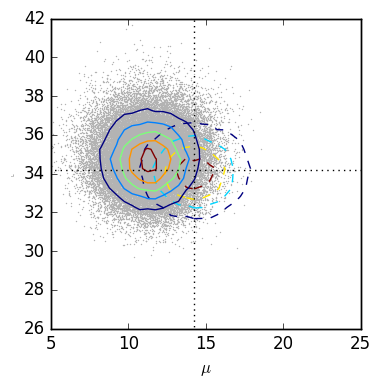

In [11]:
# consider a conjugate prior

#parameters of prior
nu0 = 10.0
sigma02 = 40**2
kappa0 = 100
mu0 = 3.

n = np.float(len(y))
N = 50000

#sample mean and variance
y_bar = np.sum(y)/n
s2 = np.sum((y-y_bar)**2)/(n-1)

#parameters of the posterior density
mun = kappa0*mu0/(kappa0+n)+n/(kappa0+n)*y_bar
kappan = kappa0+n
nun = nu0+n
nunsigman2 = nu0*sigma02+(n-1)*s2+\
    kappa0*n*(y_bar-mu0)**2/(kappa0+n)

#step 1: sample sigma2
sigma2_c = randDraw_SInvChi2(nun,\
            nunsigman2/nun, N)
#step 2: sample mu
mu_c = np.random.normal(mun,np.sqrt(sigma2_c/kappan))

#draw joint distribution obtained 
# from the sampling
hmusig_c,xedge,yedge = np.histogram2d(\
    mu_c.reshape((len(mu_c),)), \
    np.sqrt(sigma2_c.reshape(\
        (len(sigma2_c),))), bins=[xgrid,ygrid])

fig = plt.figure(figsize=[4,4])
ax = fig.add_subplot(111)
ax.plot(mu_c,np.sqrt(sigma2_c),'.',\
        color=[0.7,0.7,0.7],markersize=1)
ax1 = ax.twinx()
ax1.contour(xmesh,ymesh,hmusig.T,6,\
            linestyles='dashed',\
            color='r',extent=[xcenter[0],\
            xcenter[-1],ycenter[0],ycenter[-1]])
ax1.contour(xmesh,ymesh,hmusig_c.T,6,\
            color='k',extent=[xcenter[0],\
            xcenter[-1],ycenter[0],ycenter[-1]])
ax1.plot([np.mean(mu),np.mean(mu)],[0,100],'k:')
ax1.plot([-100,100],[np.mean(np.sqrt(sigma2)),\
            np.mean(np.sqrt(sigma2))],'k:')
ax.set_xlabel(r'$\mu$',fontsize=12)
ax.set_ylabel(r'\ $\sigma$',fontsize=2)
ax.set_xlim([5,25])
ax.set_ylim([26,42])
ax1.set_xlim([5,25])
ax1.set_ylim([26,42])
ax1.set_yticks([])

fig.show()

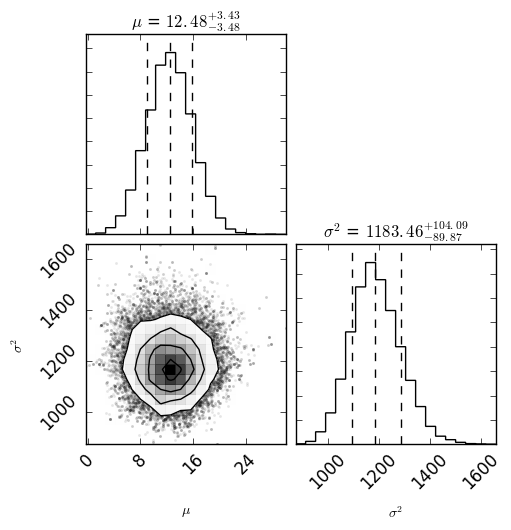

In [12]:
import emcee
import corner

def N_Scl_invChi2ln(x, mu,nu,kappa,sigma2):
    if x[1]<0:
        return -1e50
    else:
        return Scl_InvChi2ln(x[1],\
            nu,sigma2)+stats.norm.logpdf(x[0],\
            loc=mu, scale=x[1]/kappa)
    

n = np.float(len(y))

#sample mean and variance
y_bar = np.sum(y)/n
s2 = np.sum((y-y_bar)**2)/(n-1)

#parameters of the prior density
nu0 = 1.
sigma02 = 40**2
kappa0 = 50
mu0 = 3.
#parameters of the posterior density
mun = kappa0*mu0/(kappa0+n)+n/(kappa0+n)*y_bar
kappan = kappa0+n
nun = nu0+n
nunsigman2 = nu0*sigma02+(n-1)*s2+kappa0*n*\
    (y_bar-mu0)**2/(kappa0+n)
sigman2 = nunsigman2/nun

ndim = 2

nwalkers = 50

p0=np.zeros((nwalkers,ndim))
p0[:,0] = np.random.rand(nwalkers)*30.-15.
p0[:,1] = np.random.rand(nwalkers)*50.+10.
    
sampler = emcee.EnsembleSampler(nwalkers, \
    ndim, N_Scl_invChi2ln, args=[mun,nun,kappan,sigman2])

pos, prob, state = sampler.run_mcmc(p0, 100)
sampler.reset()

sampler.run_mcmc(pos, 1000)

samples = sampler.chain[:, 100:, :].reshape((-1, ndim))

fig = corner.corner(samples,\
        labels=[r"$\mu$", r"$\sigma^2$"],\
        quantiles=[0.16, 0.5, 0.84],\
        show_titles=True, title_kwargs={"fontsize": 12})
